### Переходим к практике

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
# Необходимо для скачивания пакета stopwords
#import nltk
#nltk.download('stopwords')

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 32.1 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 30s


А теперь в 3 строчки обучим нашу модель

In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [14]:
common_dictionary[10]

'ватутин'

In [15]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 3),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 3),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [16]:
from gensim.models import LdaModel

In [17]:
LdaModel?

In [18]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 41.3 s


In [19]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [20]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(10, 0.19350551),
 (11, 0.032360148),
 (15, 0.16123818),
 (16, 0.091473795),
 (20, 0.47456798),
 (24, 0.029900663)]

In [21]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: отряд офицер сон проживать боевик террорист провинция
topic_1: год ребёнок возраст жизнь рак человек болезнь
topic_2: пострадать продукция автомобиль авария образоваться район производить
topic_3: население экономика остров министерство энергия технология журнал
topic_4: греция продолжительность армения греческий эстония сергеев си
topic_5: это президент страна который государство глава решение
topic_6: дождь атмосферный вред сутки собственник мвд снежный
topic_7: сенатор датчик достопримечательность заполнить рим ввс mailn
topic_8: проверка убийство орган мвд сотрудник правоохранительный следователь
topic_9: товар nn квартира открытие теория ндс золото
topic_10: мозг доллар исследование дональд способность автор необычный
topic_11: фонд проект nn фестиваль москва программа сайт
topic_12: компания россия банк российский это который рф
topic_13: сша китай американский украина китайский северный год
topic_14: год рубль млн млрд рост цена рынок
topic_15: это год мочь который весь

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [22]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050614,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0000
1,4896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.606424,0.000000,0.0,0.199308,0.0,0.000000,0.0,0.0000
2,4897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.161369,0.091443,0.000000,0.000000,0.0,0.474523,0.0,0.000000,0.0,0.0299
3,4898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.103888,0.150269,0.224130,0.357289,0.0,0.000000,0.0,0.056889,0.0,0.0000
4,4899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.221663,0.000000,0.000000,0.000000,0.0,0.096568,0.0,0.000000,0.0,0.0000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [24]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [25]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [26]:
doc_dict[293622]

array([0.        , 0.04469411, 0.        , 0.03999833, 0.        ,
       0.24166912, 0.02169026, 0.        , 0.        , 0.02671842,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.15387581, 0.        , 0.11654961, 0.        ,
       0.1550626 , 0.        , 0.        , 0.15348937, 0.03714884])

In [27]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [28]:
get_user_embedding(user_articles_list)

array([0.        , 0.02410817, 0.        , 0.02247162, 0.        ,
       0.13489074, 0.00408643, 0.0042432 , 0.00934306, 0.03158562,
       0.00277547, 0.        , 0.19939825, 0.02015454, 0.03940039,
       0.0815846 , 0.00822864, 0.15098847, 0.0150676 , 0.04879286,
       0.        , 0.        , 0.00289503, 0.07341289, 0.11450568])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [29]:
#users['articles'].iloc[33]

In [30]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [31]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.021074,0.002286,0.006666,0.0,0.127364,0.003615,0.008336,0.005028,...,0.024548,0.028124,0.175240,0.042073,0.045027,0.076873,0.002217,0.009946,0.112910,0.097409
1,u108690,0.0,0.026961,0.002629,0.015465,0.0,0.122431,0.000000,0.000000,0.018604,...,0.108903,0.005945,0.143085,0.078378,0.055352,0.021975,0.000000,0.005826,0.023894,0.098511
2,u108339,0.0,0.007111,0.010834,0.010457,0.0,0.152826,0.013933,0.004059,0.015398,...,0.039740,0.026769,0.160094,0.013895,0.036829,0.026274,0.000000,0.000000,0.034493,0.196146


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [33]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.021074,0.002286,0.006666,0.0,0.127364,0.003615,0.008336,0.005028,...,0.028124,0.175240,0.042073,0.045027,0.076873,0.002217,0.009946,0.112910,0.097409,0
1,u108690,0.0,0.026961,0.002629,0.015465,0.0,0.122431,0.000000,0.000000,0.018604,...,0.005945,0.143085,0.078378,0.055352,0.021975,0.000000,0.005826,0.023894,0.098511,1
2,u108339,0.0,0.007111,0.010834,0.010457,0.0,0.152826,0.013933,0.004059,0.015398,...,0.026769,0.160094,0.013895,0.036829,0.026274,0.000000,0.000000,0.034493,0.196146,1


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=1)

In [36]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [37]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([7.62590471e-02, 1.02474410e-01, 8.35421058e-02, 1.14728661e-01,
       5.16146600e-01, 2.55387645e-02, 4.52512629e-04, 3.13761998e-02,
       4.54011211e-02, 1.58612864e-01])

In [38]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [39]:
import itertools

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

fscore_mean, precision_mean, recall_mean = fscore[ix], precision[ix], recall[ix]

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.237854, F-Score=0.669, Precision=0.613, Recall=0.737


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1632  117]
 [  67  184]]


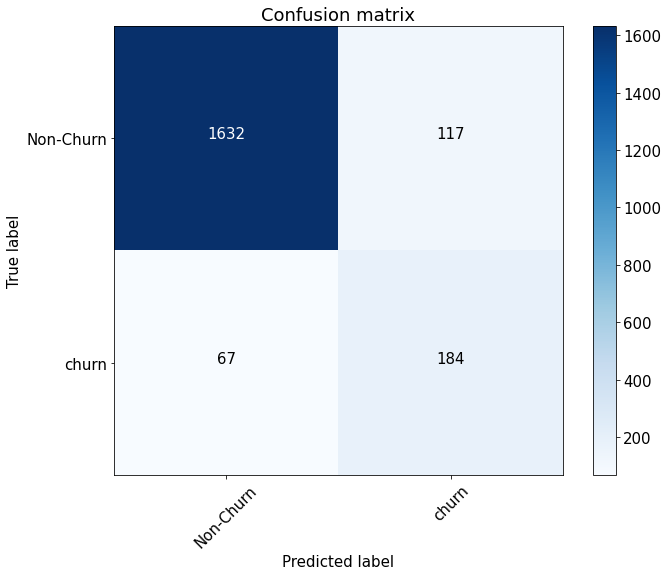

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [43]:
roc_auc_score_mean = roc_auc_score(y_test, preds)
print(roc_auc_score_mean)

0.9403256043863426


### HW_lesson_2

Создадим две новые функции get_user_embedding_median и get_user_embedding_max и просчитаем модель прогнозирования оттока.

In [44]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [45]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08767815, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.14933413, 0.        , 0.        ,
       0.07005748, 0.        , 0.12437304, 0.        , 0.01649639,
       0.        , 0.        , 0.        , 0.08967858, 0.00769348])

In [46]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.015661,0.000000,0.000000,0.0,0.061929,0.0,0.0,0.0,...,0.000000,0.000000,0.136652,0.000000,0.000000,0.016993,0.0,0.0,0.014884,0.026633
1,u108690,0.0,0.000000,0.000000,0.000000,0.0,0.111944,0.0,0.0,0.0,...,0.084181,0.000000,0.146874,0.081479,0.037080,0.009697,0.0,0.0,0.006897,0.036785
2,u108339,0.0,0.000000,0.005744,0.008385,0.0,0.108423,0.0,0.0,0.0,...,0.020006,0.008649,0.161949,0.005255,0.016862,0.026519,0.0,0.0,0.029854,0.192740


In [47]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [48]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.015661,0.000000,0.000000,0.0,0.061929,0.0,0.0,0.0,...,0.000000,0.136652,0.000000,0.000000,0.016993,0.0,0.0,0.014884,0.026633,0
1,u108690,0.0,0.000000,0.000000,0.000000,0.0,0.111944,0.0,0.0,0.0,...,0.000000,0.146874,0.081479,0.037080,0.009697,0.0,0.0,0.006897,0.036785,1
2,u108339,0.0,0.000000,0.005744,0.008385,0.0,0.108423,0.0,0.0,0.0,...,0.008649,0.161949,0.005255,0.016862,0.026519,0.0,0.0,0.029854,0.192740,1


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [50]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [51]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.35024986, 0.0398352 , 0.39587212, 0.27187308, 0.08206454,
       0.10462246, 0.02648904, 0.09998569, 0.03053021, 0.15259581])

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

fscore_median, precision_median, recall_median = fscore[ix], precision[ix], recall[ix]

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.256955, F-Score=0.686, Precision=0.607, Recall=0.788


Confusion matrix, without normalization
[[1630  125]
 [  53  192]]


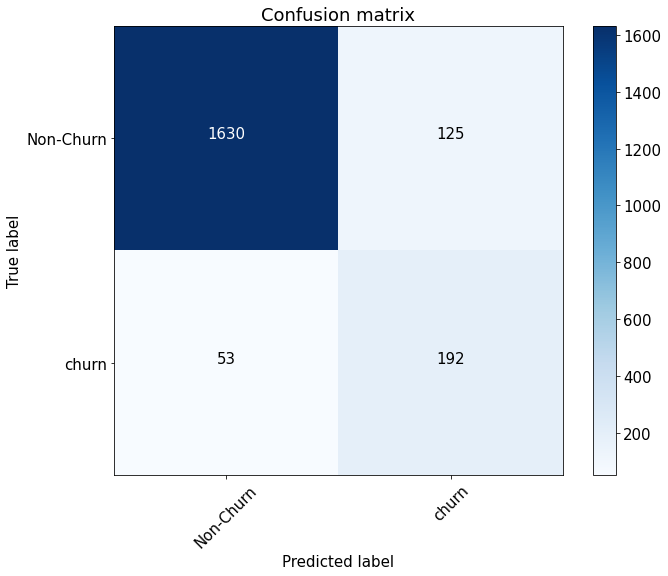

In [53]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [54]:
roc_auc_score_median = roc_auc_score(y_test, preds)
print(roc_auc_score_median)

0.9496807953950812


Повторим тоже саме для функции get_user_embedding_max

In [55]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [56]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.11340883, 0.        , 0.08367492, 0.        ,
       0.48108041, 0.02451856, 0.0254592 , 0.05605839, 0.11414766,
       0.01665279, 0.        , 0.50907654, 0.08753157, 0.22180913,
       0.216217  , 0.04937185, 0.39722705, 0.04790991, 0.13207737,
       0.        , 0.        , 0.01737017, 0.13429803, 0.54332042])

In [57]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.050430,0.013717,0.039998,0.0,0.398657,0.021690,0.050015,0.030170,...,0.119133,0.153876,0.414158,0.135891,0.270164,0.272192,0.0133,0.059677,0.494203,0.277782
1,u108690,0.0,0.161767,0.015776,0.081108,0.0,0.217220,0.000000,0.000000,0.100284,...,0.230891,0.018581,0.259371,0.189638,0.157242,0.067112,0.0000,0.034956,0.072484,0.306433
2,u108339,0.0,0.026417,0.029649,0.027908,0.0,0.368475,0.055233,0.024356,0.055148,...,0.106500,0.076524,0.380995,0.042189,0.131110,0.065468,0.0000,0.000000,0.066657,0.251467


In [58]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [59]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.050430,0.013717,0.039998,0.0,0.398657,0.021690,0.050015,0.030170,...,0.153876,0.414158,0.135891,0.270164,0.272192,0.0133,0.059677,0.494203,0.277782,0
1,u108690,0.0,0.161767,0.015776,0.081108,0.0,0.217220,0.000000,0.000000,0.100284,...,0.018581,0.259371,0.189638,0.157242,0.067112,0.0000,0.034956,0.072484,0.306433,1
2,u108339,0.0,0.026417,0.029649,0.027908,0.0,0.368475,0.055233,0.024356,0.055148,...,0.076524,0.380995,0.042189,0.131110,0.065468,0.0000,0.000000,0.066657,0.251467,1


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [61]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [62]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1080095 , 0.00927758, 0.63642748, 0.33882057, 0.28641896,
       0.00179307, 0.00962935, 0.04632006, 0.01391341, 0.19133193])

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

fscore_max, precision_max, recall_max = fscore[ix], precision[ix], recall[ix]

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.404326, F-Score=0.723, Precision=0.770, Recall=0.682


Confusion matrix, without normalization
[[1705   50]
 [  79  166]]


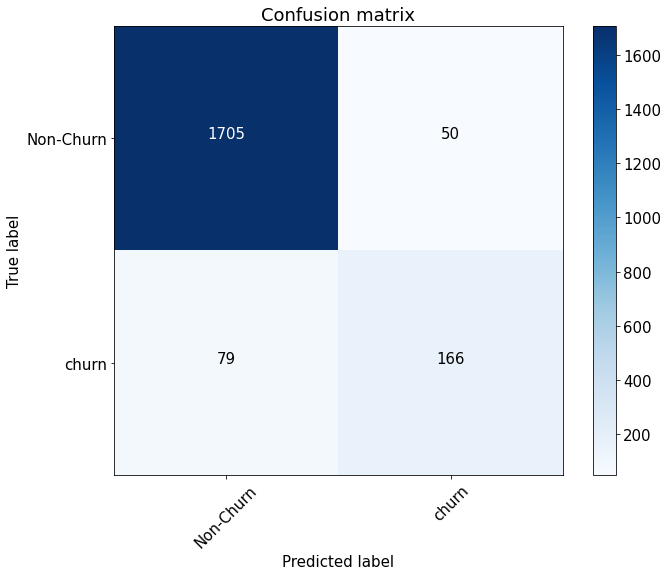

In [64]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [65]:
roc_auc_score_max = roc_auc_score(y_test, preds)
print(roc_auc_score_max)

0.9558741787313216


Соберем все данные качества в одну таблицу

In [66]:
metrix_table = pd.DataFrame([['mean', roc_auc_score_mean, precision_mean, recall_mean, fscore_mean],
                            ['median', roc_auc_score_median, precision_median, recall_median, fscore_median],
                            ['max', roc_auc_score_max, precision_max, recall_max, fscore_max]],
columns = ['method', 'roc_auc_score', 'precision', 'recall', 'f-score'])
metrix_table.round(3)

,method,roc_auc_score,precision,recall,f-score
0,mean,0.940,0.613,0.737,0.669
1,median,0.950,0.607,0.788,0.686
2,max,0.956,0.770,0.682,0.723


По результатам метрик качества, модель в которой считалась медиана показывает лучшие результаты, т.к. медиана является наиболее точным методом расчета и на нее не так критично влияют выбросы.

P.S. Перезапустив несколько раз код, результаты метрик получаются разные.